In [34]:
import os
import sys

from itertools import product

sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt

from utils.dataset import train_test_load
from utils.checkpoint import save_params, save_variational

from model.train.recommender import training_loop
from model.train.recommender_feature import training_loop as training_loop_feat
from model.train.recommender_variational import training_loop as training_loop_var

In [4]:
test_split = 0.2

train, test = train_test_load("../data/ml-32m/ratings.csv", "../data/ml-32m/movies.csv", test_split=test_split)

### Training

#### Hyperparameter Grid Search

In [3]:
records = []

lambdas = [0.01, 0.1, 0.5]
gammas  = [0.01, 0.1, 0.5]
taus    = [0.01, 0.1, 0.5]

for lmb, tau, gam in product(lambdas, taus, gammas):
    hyper_params = {
        'embedding_dim': 1,
        'r_lambda': lmb,
        'r_gamma': tau,
        'r_tau': gam,
    }

    train_loss, train_rmse, test_loss, test_rmse, _, _, _, _ = training_loop(
        train.user_movies, train.movie_users, test.user_movies, test.movie_users,
        n_iter = 20, **hyper_params
    )
        
    records.append((hyper_params, train_rmse[-1]))

In [22]:
print("Grid Search result")
for hyper_param, loss in records:
    print(f"Hyperparameter: {hyper_param} - Train loss: {loss}")

best_hyper_params, loss = min(records, key=lambda x: x[1])

del best_hyper_params["embedding_dim"]
print(f"Best Hyperparameter: {best_hyper_params} - Train loss: {loss}")

Grid Search result
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.01, 'r_tau': 0.01} - Train loss: 0.8074997663316453
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.01, 'r_tau': 0.1} - Train loss: 0.8099166114905306
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.01, 'r_tau': 0.5} - Train loss: 0.8174051613229903
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.1, 'r_tau': 0.01} - Train loss: 0.8369405576643061
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.1, 'r_tau': 0.1} - Train loss: 0.8427992592358579
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.1, 'r_tau': 0.5} - Train loss: 0.8478348106732442
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.5, 'r_tau': 0.01} - Train loss: 0.8500230469865241
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.5, 'r_tau': 0.1} - Train loss: 0.8664587858741523
Hyperparameter: {'embedding_dim

In [5]:
best_hyper_params = {'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.01}

#### Bias Only Model

In [6]:
hyper_params = {'embedding_dim': 0, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [7]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 4590580.911260951
Test Loss: 1186707.4100242485
Train RMSE: 0.8457458317833676
Test RMSE: 0.8560580605570944


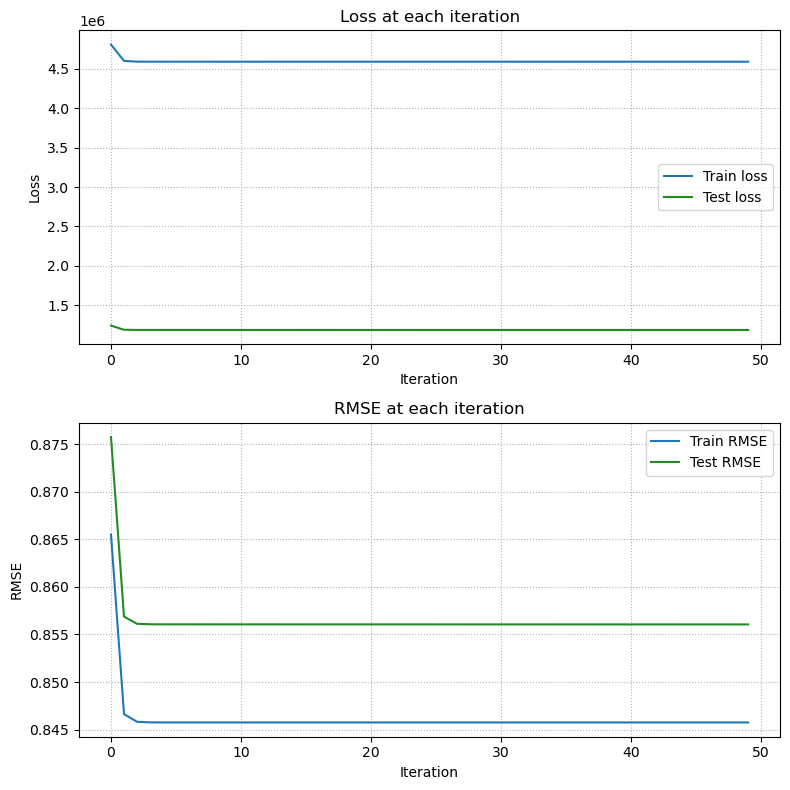

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_bias_only.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [26]:
save_params(
    "../artifacts/model/32m_users_training_bias_only", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

#### 2d Embedding Model

In [9]:
hyper_params = {'embedding_dim': 2, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [10]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 3958932.162695744
Test Loss: 1084353.9506428465
Train RMSE: 0.7849762319936157
Test RMSE: 0.8169161352731742


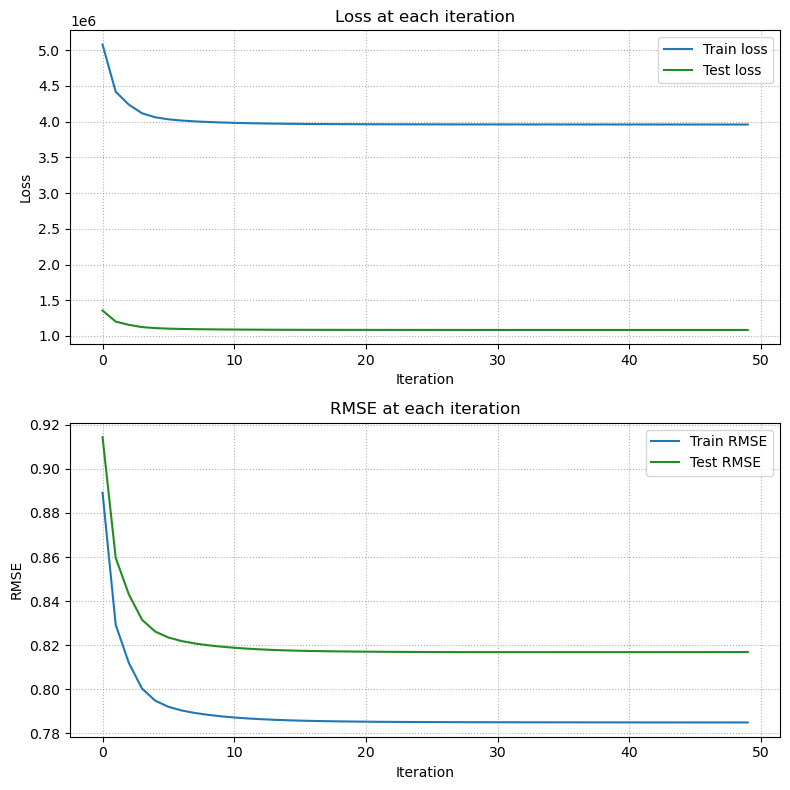

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_2.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [30]:
save_params(
    "../artifacts/model/32m_users_training_2", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

#### Embedding Dimension Search

In [ ]:
embeddings = [0, 2, 4, 8, 10, 16, 20, 32]
results_train_rmse = []
results_train_loss = []
results_test_rmse = []
results_test_loss = []

for e in embeddings:
    hyper_params = {'embedding_dim': e, **best_hyper_params}

    train_loss, train_rmse, test_loss, test_rmse, _, _, _, _ = training_loop(
        train.user_movies, train.movie_users, test.user_movies, test.movie_users,
        n_iter = 50, **hyper_params
    )

    results_train_rmse.append(train_rmse[-1])
    results_train_loss.append(train_loss[-1])
    results_test_rmse.append(test_rmse[-1])
    results_test_loss.append(test_loss[-1])

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(embeddings, results_train_rmse)
axs[0].set_xlabel("Embedding Dimension")
axs[0].set_ylabel("Train RMSE")
axs[0].set_title("Train RMSE per Embedding Dimension")
axs[0].grid(True, linestyle=":")

axs[1].plot(embeddings, results_train_loss)
axs[1].set_xlabel("Embedding Dimension")
axs[1].set_ylabel("Train Loss")
axs[1].set_title("Train Loss per Embedding Dimension")
axs[1].grid(True, linestyle=":")

plt.tight_layout()
plt.savefig("../artifacts/plot/embedding_search.pdf", format="pdf", bbox_inches='tight')
plt.show()

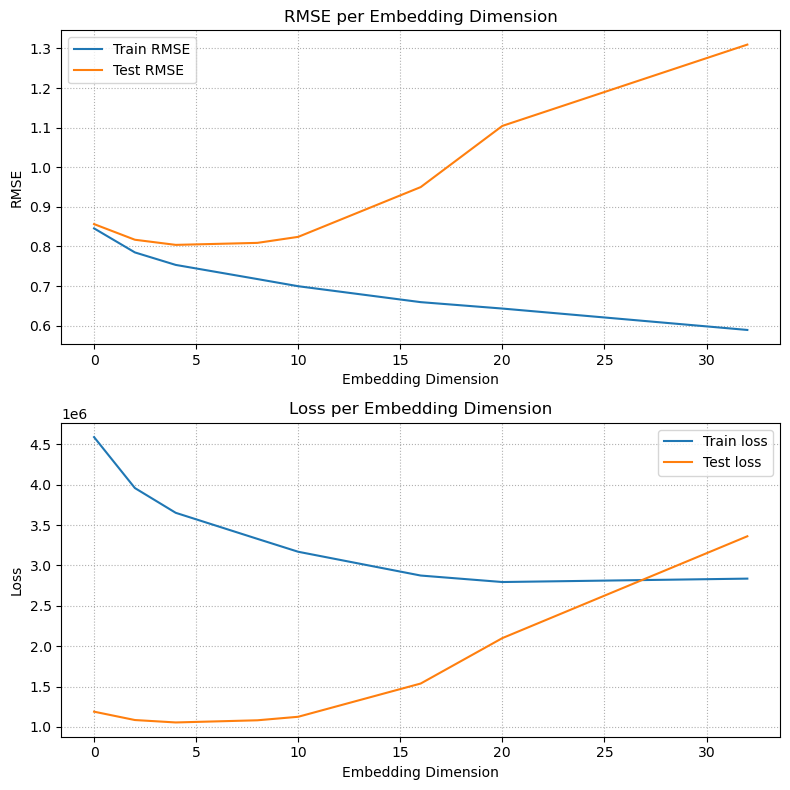

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(embeddings, results_train_rmse, label="Train RMSE")
axs[0].plot(embeddings, results_test_rmse, label="Test RMSE")
axs[0].set_xlabel("Embedding Dimension")
axs[0].set_ylabel("RMSE")
axs[0].set_title("RMSE per Embedding Dimension")
axs[0].legend()
axs[0].grid(True, linestyle=":")

axs[1].plot(embeddings, results_train_loss, label="Train loss")
axs[1].plot(embeddings, results_test_loss, label="Test loss")
axs[1].set_xlabel("Embedding Dimension")
axs[1].set_ylabel("Loss")
axs[1].set_title("Loss per Embedding Dimension")
axs[1].legend()
axs[1].grid(True, linestyle=":")

plt.tight_layout()
plt.savefig("../artifacts/plot/embedding_search_alt.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Best Model Training

In [12]:
hyper_params = {'embedding_dim': 16, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [13]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 2861297.037207429
Test Loss: 1513308.033327864
Train RMSE: 0.6589446466561435
Test RMSE: 0.9452608605946792


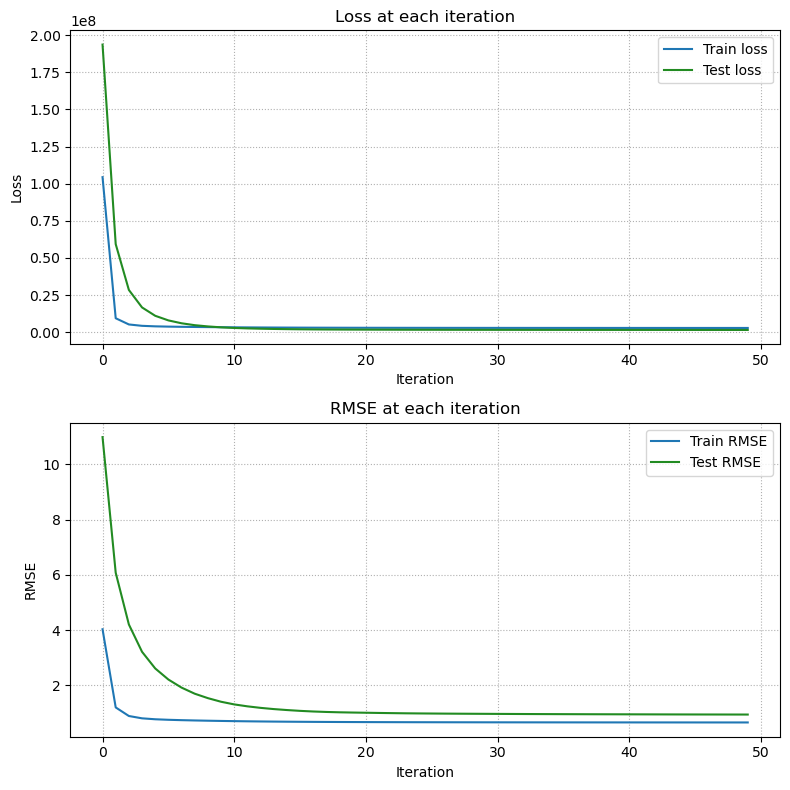

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_16.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [7]:
save_params(
    "../artifacts/model/32m_users_training_16", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

In [15]:
hyper_params = {'embedding_dim': 10, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [16]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 3178428.20247443
Test Loss: 1130894.2159880898
Train RMSE: 0.7008530528625092
Test RMSE: 0.8272531653473426


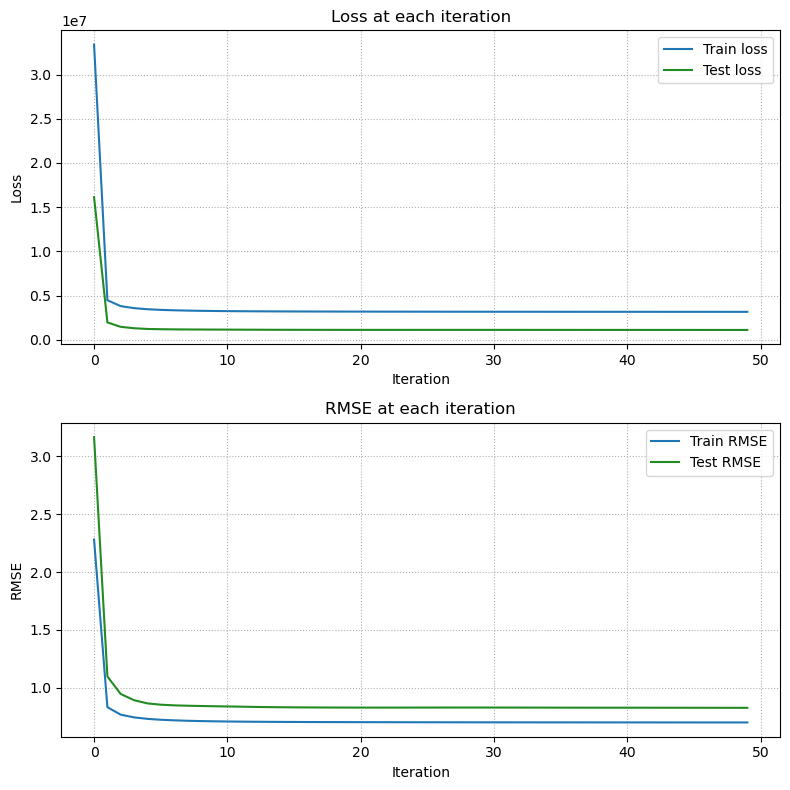

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_10.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [8]:
save_params(
    "../artifacts/model/32m_users_training_10", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

In [18]:
hyper_params = {'embedding_dim': 20, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [19]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 2767008.3872258854
Test Loss: 1893292.117388949
Train RMSE: 0.6387665352026252
Test RMSE: 1.0416776310426255


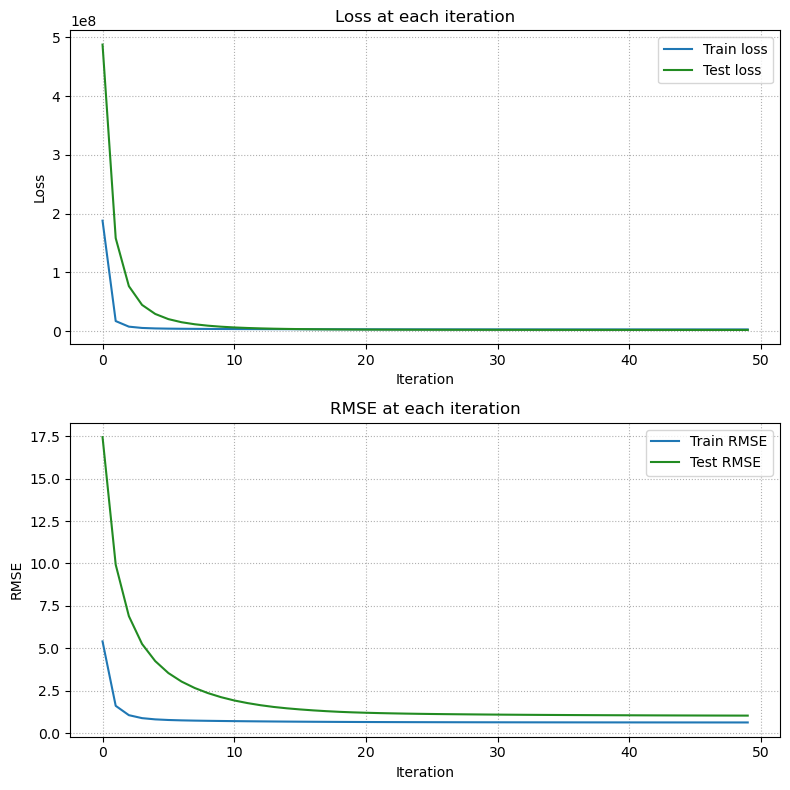

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_20.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [17]:
save_params(
    "../artifacts/model/32m_users_training_20", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

#### 2d Features Model

In [21]:
hyper_params = {'embedding_dim': 2, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings, feat_embeddings = training_loop_feat(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users, train.movie_feat, train.feat_movie,
    n_iter = 50, **hyper_params
)

In [22]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 3961051.3400501795
Test Loss: 1084848.6016432967
Train RMSE: 0.7851169768324311
Test RMSE: 0.8170955791083738


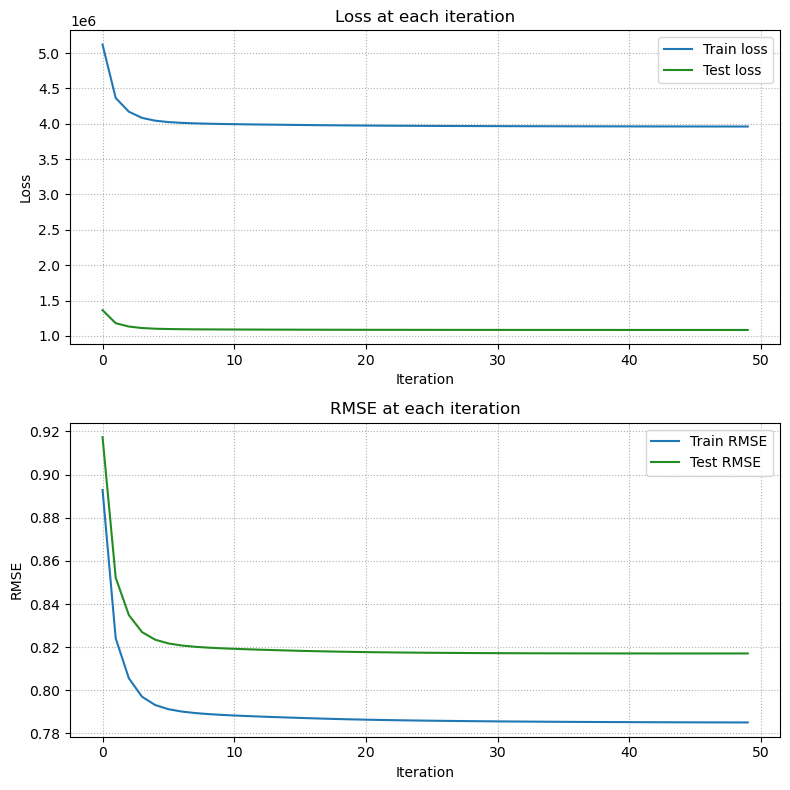

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_with_features_2.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [11]:
save_params(
    "../artifacts/model/32m_users_training_features_2", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
    train.idx_to_feat_id,
    feat_embeddings,
)

#### Model with Features Training

In [24]:
hyper_params = {'embedding_dim': 16, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings, feat_embeddings = training_loop_feat(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users, train.movie_feat, train.feat_movie,
    n_iter = 50, **hyper_params
)

In [25]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 2889598.188942707
Test Loss: 1580540.1907793537
Train RMSE: 0.6593967530362338
Test RMSE: 0.9561426367920783


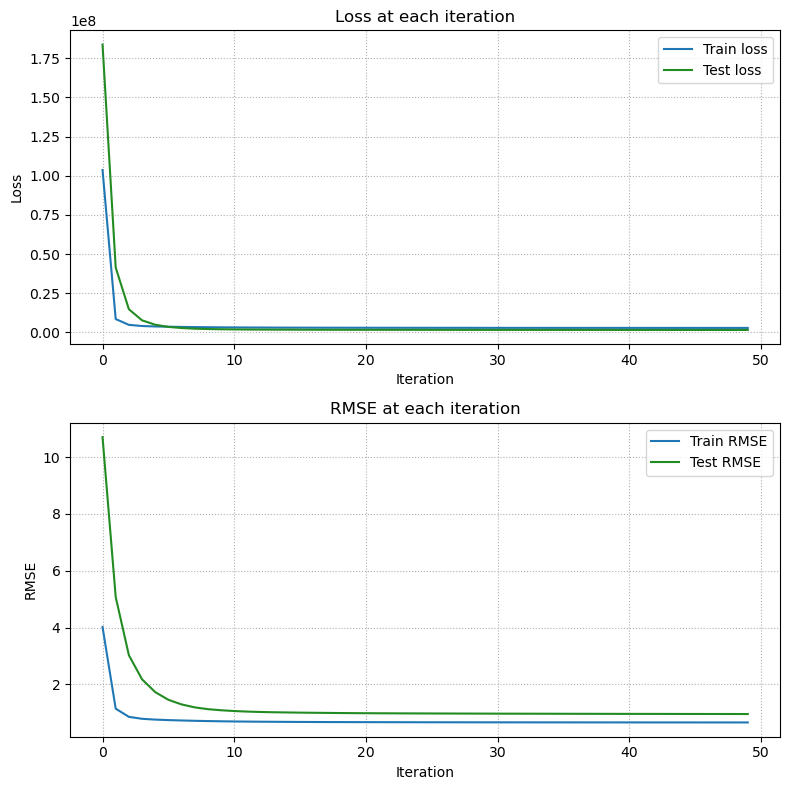

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_with_features_16.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [12]:
save_params(
    "../artifacts/model/32m_users_training_features_16", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
    train.idx_to_feat_id,
    feat_embeddings,
)

In [27]:
hyper_params = {'embedding_dim': 10, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings, feat_embeddings = training_loop_feat(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users, train.movie_feat, train.feat_movie,
    n_iter = 50, **hyper_params
)

In [28]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 3187232.237187485
Test Loss: 1148548.67337631
Train RMSE: 0.7002755390513989
Test RMSE: 0.827440045499331


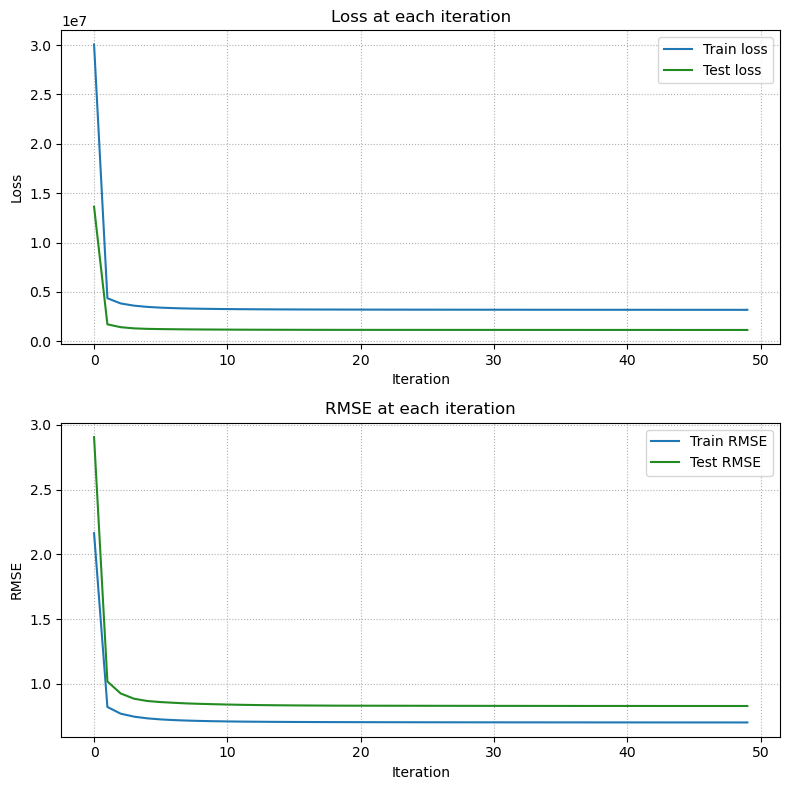

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_with_features_10.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [16]:
save_params(
    "../artifacts/model/32m_users_training_features_10", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
    train.idx_to_feat_id,
    feat_embeddings,
)

In [30]:
hyper_params = {'embedding_dim': 20, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings, feat_embeddings = training_loop_feat(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users, train.movie_feat, train.feat_movie,
    n_iter = 50, **hyper_params
)

In [31]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 2803153.887771408
Test Loss: 2344242.510585308
Train RMSE: 0.6450879555333496
Test RMSE: 1.1699155520811937


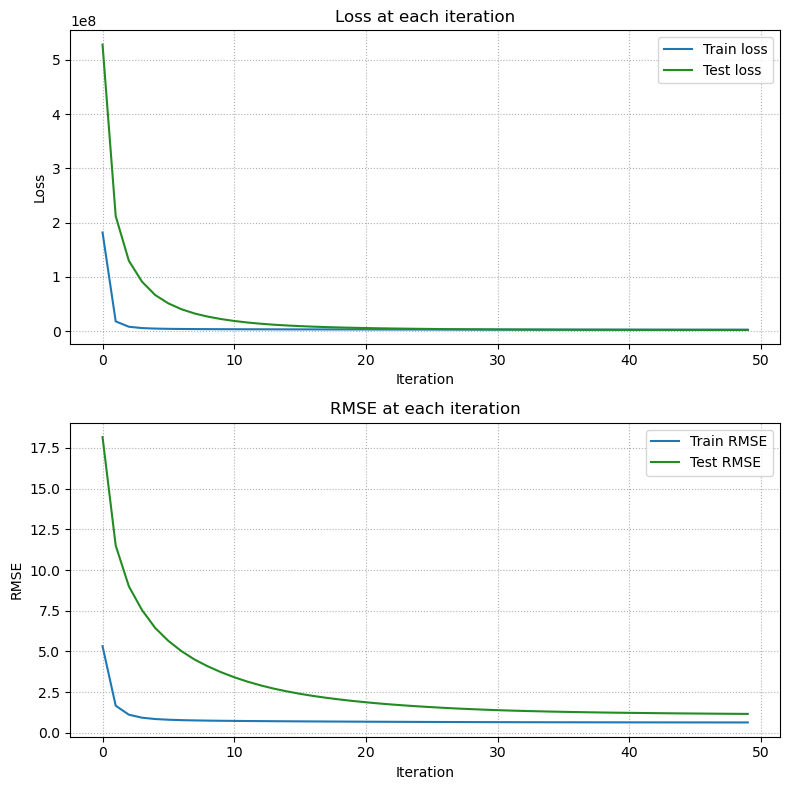

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_with_features_20.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [20]:
save_params(
    "../artifacts/model/32m_users_training_features_20", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
    train.idx_to_feat_id,
    feat_embeddings,
)

#### Variational Model

In [35]:
(
    train_loss,
    train_rmse,
    val_loss,
    val_rmse,
    user_mean_embedding,
    user_var_embedding,
    user_mean_bias,
    user_var_bias,
    movie_mean_embedding,
    movie_var_embedding,
    movie_mean_bias,
    movie_var_bias,
) = training_loop_var(
    train.user_movies,
    train.movie_users,
    test.user_movies,
    embedding_dim = 10,
    **best_hyper_params,
    n_iter = 50,
)

In [36]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", val_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", val_rmse[-1])

## Results ##
Train Loss: -3572229.9624399296
Test Loss: -8950774.260015726
Train RMSE: 0.7745072274249208
Test RMSE: 0.844053048195516


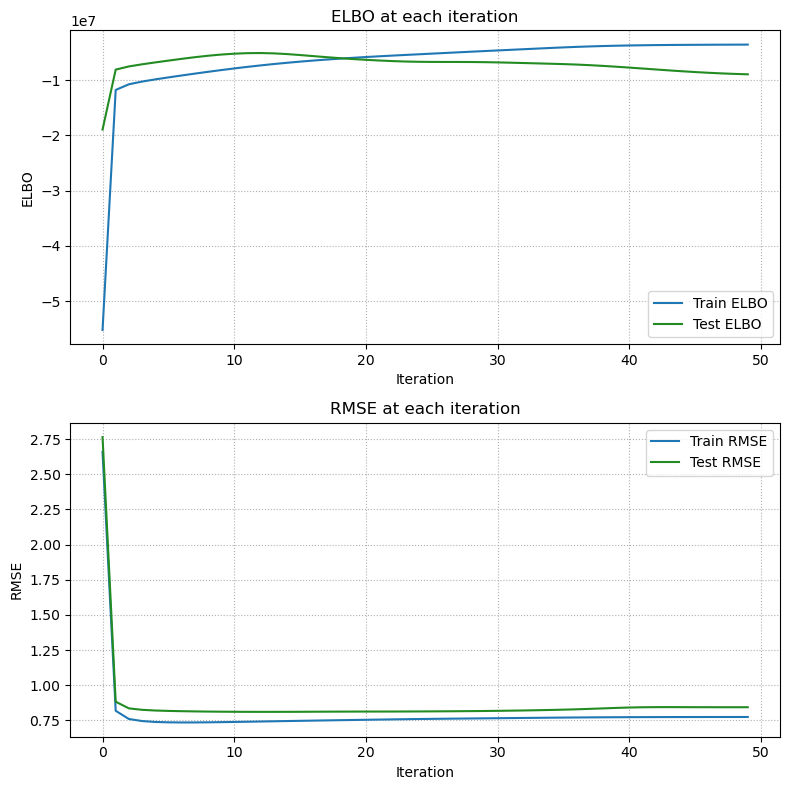

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train ELBO")
axs[0].plot(val_loss, color="forestgreen", label="Test ELBO")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("ELBO")
axs[0].set_title("ELBO at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(val_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_variational_10.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [39]:
save_variational(
    "../artifacts/model/32m_variational_10", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_mean_bias,
    user_var_bias,
    movie_mean_bias,
    movie_var_bias,
    user_mean_embedding,
    user_var_embedding,
    movie_mean_embedding,
    movie_var_embedding,
)

In [40]:
(
    train_loss,
    train_rmse,
    val_loss,
    val_rmse,
    user_mean_embedding,
    user_var_embedding,
    user_mean_bias,
    user_var_bias,
    movie_mean_embedding,
    movie_var_embedding,
    movie_mean_bias,
    movie_var_bias,
) = training_loop_var(
    train.user_movies,
    train.movie_users,
    test.user_movies,
    embedding_dim = 20,
    **best_hyper_params,
    n_iter = 50,
)

In [41]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", val_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", val_rmse[-1])

## Results ##
Train Loss: -950046.2997048981
Test Loss: -12762755.148864098
Train RMSE: 0.767575989747528
Test RMSE: 0.8249541983155962


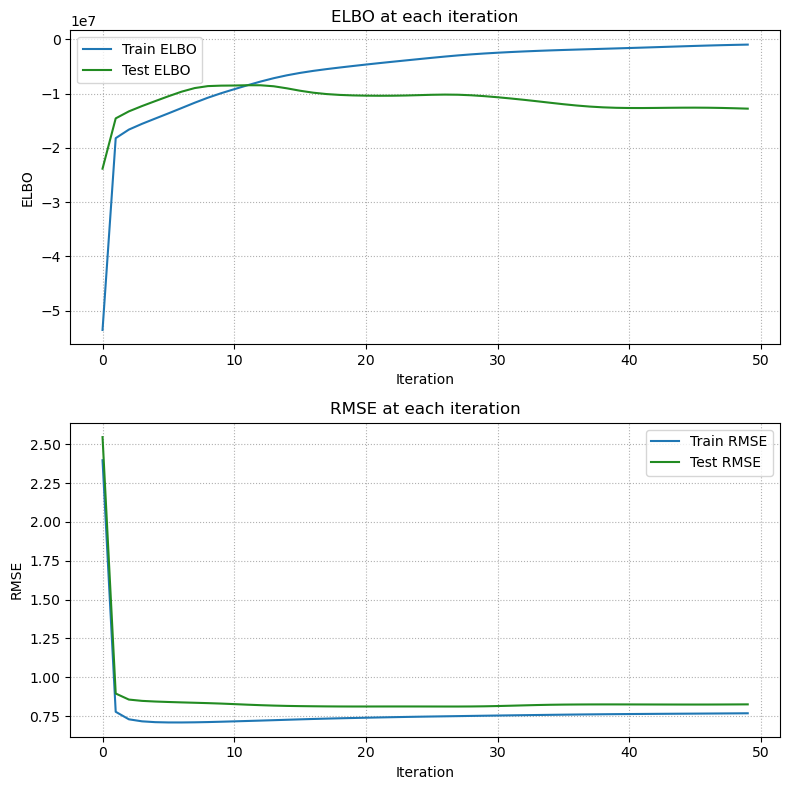

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train ELBO")
axs[0].plot(val_loss, color="forestgreen", label="Test ELBO")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("ELBO")
axs[0].set_title("ELBO at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(val_rmse, color="forestgreen", label="Test RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_variational_20.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [43]:
save_variational(
    "../artifacts/model/32m_variational_20", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_mean_bias,
    user_var_bias,
    movie_mean_bias,
    movie_var_bias,
    user_mean_embedding,
    user_var_embedding,
    movie_mean_embedding,
    movie_var_embedding,
)

---